Дашборд

https://public.tableau.com/app/profile/ksenia7929/viz/Retailproject_16534869050960/Dashboard1?publish=yes

Презентация

https://disk.yandex.ru/d/MO5_3libfG7_RA

# Анализ программы лояльности 

## Описание проекта

Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.

Цель:

* Дать рекомендации к программе лояльности магазина

Задачи:

* Провести анализ программы лояльности на основании данных о покупках клиентов

## Изучение и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
sns.set(rc = {'figure.figsize':(10, 7)}) 
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
retail = pd.read_csv('/datasets/retail_dataset.csv')
retail.head(10)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00
5,538379,22965,0,2016-12-12 11:26:00,22805.00,Shop 0,1.00
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.00
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.00
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.00
9,539501,22372,0,2016-12-20 11:08:00,22764.00,Shop 0,1.00


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [5]:
product = pd.read_csv('/datasets/product_codes.csv')
product.head(10)

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
5,22752,7.65
6,21730,4.25
7,22633,1.85
8,22632,1.85
9,84879,1.69


In [6]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Первое, что надо исправить - записать название столбцов в едином регистре. Поменять тип данных в столбцах. Также у нас есть пропуски в столбце CustomerID. Надо выяснить причину и принять решение, что с ними делать.

### Работа с названием колонок

Для удобства дальнейшей работы переименуем название столбцов. Приведем их к "змеиному" регистру

In [7]:
retail.columns

Index(['purchaseid', 'item_ID', 'Quantity', 'purchasedate', 'CustomerID',
       'ShopID', 'loyalty_program'],
      dtype='object')

In [8]:
retail.columns = ['purchase_id', 'product_id', 'quantity', 'purchase_date', 'customer_id',
       'shop_id', 'loyalty_program']
retail.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00


In [9]:
product.columns

Index(['productID', 'price_per_one'], dtype='object')

In [10]:
product.columns = ['product_id', 'price_per_one']
product.head()

,product_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


### Работа с пропущенными значений

Посчитаем общее количество и процент пропусков в столбце customer_id

In [11]:
total = retail['customer_id'].isnull().sum()
display(total)
percent = ((retail['customer_id'].isnull().sum() / retail['customer_id'].isnull().count())*100).round(2)
display(percent)

36210

34.38

У нас 34% пропущенных значений в столбце customer_id. Это достаточно много для удаления. 

Посмотрим записи, где есть пропущенные значения. Возможно пропуски у того, кто не является участником программы лояльности?

In [12]:
retail.loc[retail['customer_id'].isnull()]

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.00
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.00
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.00
11,541696,22197,4,2017-01-20 18:08:00,NaN,Shop 0,0.00
16,539744,22300,5,2016-12-21 15:21:00,NaN,Shop 0,0.00
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,NaN,Shop 0,0.00
105326,540681,22227,1,2017-01-10 16:25:00,NaN,Shop 0,0.00
105327,538349,22625,0,2016-12-10 14:59:00,NaN,Shop 0,0.00
105329,540154,22134,3,2017-01-05 11:30:00,NaN,Shop 0,0.00


In [13]:
print(retail.loc[retail['customer_id'].isnull()]['loyalty_program'].value_counts())

0.00    36210
Name: loyalty_program, dtype: int64


Везде, где есть пропуски в customer_id - покупка осуществлена покупателем не из программы лояльности. Но если посмотреть все данные, то можно увидеть, что даже тот, кто имеет customer_id - может не являться участником программы лояльности.

In [14]:
retail.sample(5)

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
11019,542812,21355,0,2017-02-01 11:21:00,20529.00,Shop 0,0.00
46032,536762,20971,11,2016-12-02 14:40:00,21865.00,Shop 0,0.00
99385,541104,21993,1,2017-01-13 14:29:00,NaN,Shop 0,0.00
90882,536971,22969,11,2016-12-03 13:40:00,18458.00,Shop 9,0.00
14977,537153,22975,11,2016-12-05 13:03:00,22397.00,Shop 0,1.00


Возможно, что действительно тот, кто не имеет customer_id - не является участником программы лояльности. А причина, почему у тех customer_id есть, а признак участия в проограмме отсутствует, может объясняться тем, что товар, который они приобрели не участвует в никаких акциях и участие в программе никак не повлияло на стоимость товара.

Для нашего исследования эти пропуски не столь важны, но удалять записи с ними нежелательно, поэтому заменим пропущенные id покупателей на единицы.

In [15]:
retail['customer_id'] = retail['customer_id'].fillna(1)
retail.sample(10)

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
36104,542777,21259,1,2017-02-01 08:31:00,20590.00,Shop 6,0.00
50339,541002,21380,5,2017-01-13 10:33:00,18630.00,Shop 0,0.00
87840,537382,85199S,1,2016-12-06 13:13:00,22389.00,Shop 0,1.00
43407,541008,21084,2,2017-01-13 10:48:00,23527.00,Shop 0,1.00
48976,539933,72741,8,2016-12-23 11:24:00,20914.00,Shop 0,0.00
75899,540551,21555,2,2017-01-10 09:43:00,1.00,Shop 0,0.00
59539,539750,22728,1,2016-12-21 15:40:00,1.00,Shop 0,0.00
23399,537880,21588,11,2016-12-09 09:14:00,18642.00,Shop 0,0.00
51065,536544,22560,0,2016-12-01 14:32:00,1.00,Shop 0,0.00
27159,544180,21071,11,2017-02-16 14:48:00,19988.00,Shop 0,0.00


### Работа с соответствием типов данных

Следует заменить тип данных в  loyalty_program на int, в customer_id на int, а purchase_date на datetime

In [16]:
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'], format='%Y-%m-%dT%H:%M:%S')
retail['loyalty_program'] = retail['loyalty_program'].astype('int')
retail['customer_id'] = retail['customer_id'].astype('int')

Столбцы product_id и purchase_id имеют как цифры, так и буквы, оставляем тип данных изначальный.

In [17]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   product_id       105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      105335 non-null  int64         
 5   shop_id          105335 non-null  object        
 6   loyalty_program  105335 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 5.6+ MB


В датафрейме product типы данных корректны

### Работа с дубликатами

Посмотрим общее количество дубликатов

In [18]:
retail.duplicated().sum()

1033

Посмотрим на эти строки

In [19]:
retail.loc[retail.duplicated(), :]

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
5345,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0
5863,540803,21485,0,2017-01-11 12:30:00,20348,Shop 0,0
6893,540524,21326,11,2017-01-09 12:53:00,22414,Shop 0,1
7821,537192,22585,0,2016-12-05 13:42:00,22081,Shop 0,1
10806,537772,22080,4,2016-12-08 12:35:00,23722,Shop 0,1
...,...,...,...,...,...,...,...
105164,542224,22178,5,2017-01-26 12:45:00,23567,Shop 0,1
105173,544153,82552,1,2017-02-16 12:11:00,21035,Shop 0,0
105178,540839,21123,0,2017-01-11 15:42:00,22470,Shop 0,1
105229,543277,21533,0,2017-02-06 14:33:00,21487,Shop 0,0


In [20]:
retail.query('product_id=="21499" and purchase_id=="537265"')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
1700,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0
5345,537265,21499,24,2016-12-06 11:26:00,21598,Shop 0,0


Дубликаты могли возникнуть из-за того, что продавец пробивал каждый товар, даже если он был одинаковый. Или отсчитывал частями, писал количество и пробивал.

In [21]:
product.duplicated().sum()

0

В данным датафрейме нет дубликатов.

Добавим дату покупки, это должно быть удобнее, чем использовать дату со временем

In [22]:
retail['date'] = retail['purchase_date'].values.astype('datetime64[D]')
retail.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13


### Вывод

Данные обработаны и готовы к дальнейшему анализу

## Исследовательский анализ данных

### Работа с выбросами

Рассмотрим датафрейм retail при помощи метода describe. Может увидим что-то интересное

In [23]:
retail.describe(include = "all")

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
count,105335,105335,105335.00,105335,105335.00,105335,105335.00,105335
unique,4894,3159,NaN,4430,NaN,31,NaN,68
top,537434,85123A,NaN,2016-12-06 16:57:00,NaN,Shop 0,NaN,2016-12-06 00:00:00
freq,675,565,NaN,675,NaN,97393,NaN,3878
first,NaN,NaN,NaN,2016-12-01 08:26:00,NaN,NaN,NaN,2016-12-01 00:00:00
last,NaN,NaN,NaN,2017-02-28 17:04:00,NaN,NaN,NaN,2017-02-28 00:00:00
mean,NaN,NaN,7.82,NaN,13794.04,NaN,0.23,NaN
std,NaN,NaN,327.95,NaN,10084.87,NaN,0.42,NaN
min,NaN,NaN,-74216.00,NaN,1.00,NaN,0.00,NaN
25%,NaN,NaN,0.00,NaN,1.00,NaN,0.00,NaN


По столбцу quantity мы видим очень большое максимальнок количество. Как будто кто-то поштучно купил гвоздики или винтики. И при этом вернул их. Также надо заметить, что у нас достаточно много количества товра со значением "0".

В данных представлен период за декабрь 2016, январь и февраль 2017. Максимальное количество покупок было 06.12.2016

Самое большое количество товара продано в Shop 0, а всего представлен 31 магазин.

Построим график

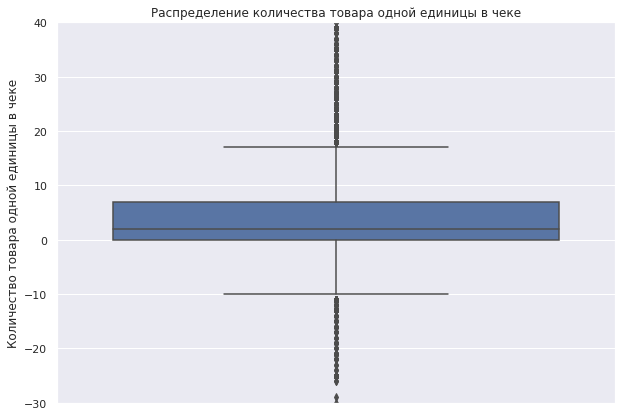

In [24]:
ax = sns.boxplot(y=retail['quantity'])
ax.set(ylim = (-30, 40))
ax.set_title('Распределение количества товара одной единицы в чеке')
plt.ylabel('Количество товара одной единицы в чеке')
plt.show()

Посчитаем кваритили

In [25]:
Q1 = retail['quantity'].quantile(0.25)
Q3 = retail['quantity'].quantile(0.75)
IQR = Q3 - Q1
print('Первый квартиль: {:.0f}'.format(Q1))
print('Третий квартиль: {:.0f}'.format(Q3))
print('Межквартильный размах: {:.0f}'.format(IQR))

Первый квартиль: 0
Третий квартиль: 7
Межквартильный размах: 7


Посчитала квартили и еще раз убедились, что у нас достаточно товаров в чеке с количеством "0". Возможно это товары по акции и подарки по программе лояльности или ошибка в системе.Эти товары стоит оставить, при удалении изменится количество позиций в чеке.

Так как хвосты у распределений длинные, примем за выбросы наблюдения, выходящие за 3 IQR от Q1 и Q3:

In [26]:
print('Верхний порог: {:.0f} единиц'.format(Q3 + 3*IQR))

Верхний порог: 28 единиц


Отфилитруем датафрейм по верхней границе. Берем как положительный, так и отрицательный порог, так как у нас есть возвраты.

In [27]:
retail_filter = retail.query('quantity > -28 & quantity < 28')
retail_filter

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13
...,...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,1,Shop 0,0,2016-12-13
105331,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,0,2017-01-05
105332,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,1,2016-12-09
105333,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,0,2016-12-10


Удалили около 5% записей, это достаточно много.  "Очищенный" датафрейм будем использовать при статистической проверке гипотез.

Рассмотрим другой датафрейм

In [28]:
product.describe()

,price_per_one
count,9969.00
mean,19.50
std,330.88
min,0.00
25%,1.25
50%,2.55
75%,5.51
max,16888.02


Максимальная стоимость товара почти 17000 при средней цене 19.50.

Построим график

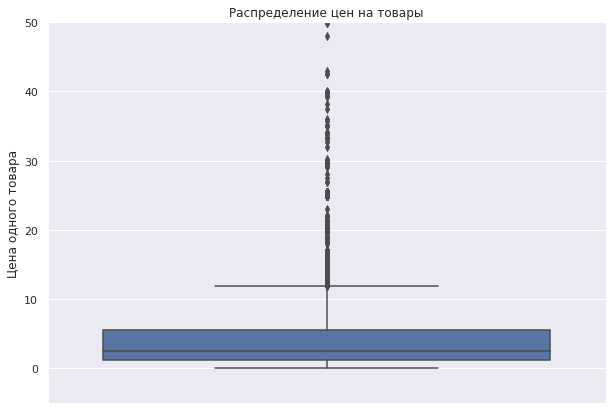

In [29]:
ax = sns.boxplot(y=product['price_per_one'])
ax.set(ylim = (-5, 50))
ax.set_title('Распределение цен на товары')
plt.ylabel('Цена одного товара')
plt.show()

Также у нас есть стоимость товара "0".

In [30]:
product['price_per_one'].value_counts()

1.25       504
0.85       493
0.00       382
2.51       371
2.46       329
          ... 
1126.00      1
8.15         1
50.60        1
32.69        1
324.43       1
Name: price_per_one, Length: 586, dtype: int64

Товаров с ценой ноль - 382 штуки.

Проверим соответствие количества цен количеству товаров

In [31]:
print('Кол-во записей с ценами: {:}'.format(product['price_per_one'].count()))
print('Кол-во уникальных товаров: {:}'.format(product['product_id'].nunique()))

Кол-во записей с ценами: 9969
Кол-во уникальных товаров: 3159


Понимаем, что есть товары с разной ценой. Посмотрим один из:

In [32]:
product.loc[product['product_id'] == '79321']

,product_id,price_per_one
144,79321,3.82
484,79321,4.95
1134,79321,10.17
1404,79321,4.25
2882,79321,11.02
5781,79321,0.00
6164,79321,3.98
7915,79321,9.96
8572,79321,10.79
9186,79321,5.75


На товар 79321 11 разных цен. Неизвестно причина этого. Возможно просто изменение цены, акции, цена по программе лояльности, товар в подарок. Оптимальный вариант - усреднить.

In [33]:
product_mean = product.groupby('product_id').agg(mean_price = ('price_per_one', 'mean')).reset_index()
product_mean.head()

,product_id,mean_price
0,10002,1.38
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


Еще мы помним, что есть высокие цены на товары - выбросы. Посмотрим на товары с ценой больше 50

In [34]:
product_mean.loc[product_mean['mean_price'] > 50]

,product_id,mean_price
773,21769,66.36
1507,22655,228.50
1508,22656,150.00
1668,22823,117.50
1671,22826,175.00
1672,22827,155.00
1673,22828,155.00
1770,22929,61.48
2241,84078A,56.60
2374,84632,59.95


AMAZONFEE, BANK CHARGES,DOT лидирует по средней стоимости товара.

In [35]:
retail.loc[retail['product_id'].isin(['AMAZONFEE'])]

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
1181,C537652,AMAZONFEE,-2,2016-12-07 15:51:00,1,Shop 0,0,2016-12-07
2637,C544589,AMAZONFEE,-2,2017-02-21 15:11:00,1,Shop 0,0,2017-02-21
8119,C540117,AMAZONFEE,-2,2017-01-05 09:55:00,1,Shop 0,0,2017-01-05
12550,537632,AMAZONFEE,0,2016-12-07 15:08:00,1,Shop 0,0,2016-12-07
24571,C537630,AMAZONFEE,-2,2016-12-07 15:04:00,1,Shop 0,0,2016-12-07
34815,C537651,AMAZONFEE,-2,2016-12-07 15:49:00,1,Shop 0,0,2016-12-07
35911,C537644,AMAZONFEE,-2,2016-12-07 15:34:00,1,Shop 0,0,2016-12-07
58981,C540118,AMAZONFEE,-2,2017-01-05 09:57:00,1,Shop 0,0,2017-01-05
59911,C537647,AMAZONFEE,-2,2016-12-07 15:41:00,1,Shop 0,0,2016-12-07
63101,C544587,AMAZONFEE,-2,2017-02-21 15:07:00,1,Shop 0,0,2017-02-21


Видимо магазин продает на маркетплейсе Amazon. И в данных мы видим только возвраты и одну покупку с количеством товара "0"

In [36]:
retail.loc[retail['product_id'].isin(["BANK CHARGES"])]

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
1514,C544575,BANK CHARGES,-2,2017-02-21 13:58:00,1,Shop 0,0,2017-02-21
5032,C538680,BANK CHARGES,-2,2016-12-13 17:10:00,1,Shop 0,0,2016-12-13
10771,541505,BANK CHARGES,0,2017-01-18 15:58:00,21618,Shop 0,0,2017-01-18
49870,C544049,BANK CHARGES,-2,2017-02-15 12:39:00,1,Shop 0,0,2017-02-15
55236,C537572,BANK CHARGES,-2,2016-12-07 12:00:00,1,Shop 0,0,2016-12-07
75879,C541653,BANK CHARGES,-2,2017-01-20 11:50:00,1,Shop 0,0,2017-01-20
81548,536779,BANK CHARGES,0,2016-12-02 15:08:00,21502,Shop 0,0,2016-12-02
87595,C544584,BANK CHARGES,-2,2017-02-21 14:52:00,1,Shop 0,0,2017-02-21
104690,C544576,BANK CHARGES,-2,2017-02-21 14:01:00,1,Shop 0,0,2017-02-21


BANK CHARGES- это банковская комиссия, но также еть строчки, как с возратом, так и покупкой товара в количестве "0"

In [37]:
retail.loc[retail['product_id'].isin(["DOT"])].tail(10)

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
97684,540551,DOT,0,2017-01-10 09:43:00,1,Shop 0,0,2017-01-10
99742,539738,DOT,0,2016-12-21 15:19:00,1,Shop 0,0,2016-12-21
100587,541827,DOT,0,2017-01-21 17:05:00,1,Shop 0,0,2017-01-21
100749,539748,DOT,0,2016-12-21 15:23:00,1,Shop 0,0,2016-12-21
101479,539434,DOT,0,2016-12-17 14:41:00,1,Shop 0,0,2016-12-17
101675,544812,DOT,0,2017-02-23 15:58:00,1,Shop 0,0,2017-02-23
102383,537645,DOT,0,2016-12-07 15:34:00,1,Shop 0,0,2016-12-07
103270,544771,DOT,0,2017-02-23 11:12:00,1,Shop 0,0,2017-02-23
103294,544204,DOT,0,2017-02-17 10:30:00,1,Shop 0,0,2017-02-17
103374,544767,DOT,0,2017-02-23 11:10:00,1,Shop 0,0,2017-02-23


Товары DOT по количеству "нулевые". При расчете мало что изменят.

На расчет среднего чека влияет количетсво позиций в чеке, поэтому я считаю надо оставлять все эти строчки.

### Расчет выручки по магазинам

Объединяем датафреймы retail и product_mean и добавим общую сумму покупки

In [38]:
#объединим таблицы при помощи функции merge по столбцу 'product_id', сохранив все записи retail
retail_df = pd.merge(retail, product_mean, on = 'product_id', how = 'left')
retail_df['buy_sum'] = retail_df['quantity'] * retail_df['mean_price']
retail_df.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00


Делаем сводную таблицу по магазинам с суммарной выручкой по каждому

In [39]:
#группировка методом groupby по id магазина
revenue_grouped = retail_df.groupby('shop_id').agg(revenue = ('buy_sum', 'sum'))
revenue_grouped = revenue_grouped.sort_values(by = 'revenue', ascending = False).head(10).reset_index()
revenue_grouped

,shop_id,revenue
0,Shop 0,1577567.47
1,Shop 3,103976.00
2,Shop 6,56596.73
3,Shop 4,51492.39
4,Shop 1,47599.85
5,Shop 2,40522.18
6,Shop 14,22796.61
7,Shop 8,16173.07
8,Shop 7,11115.45
9,Shop 19,10131.93


Построим график

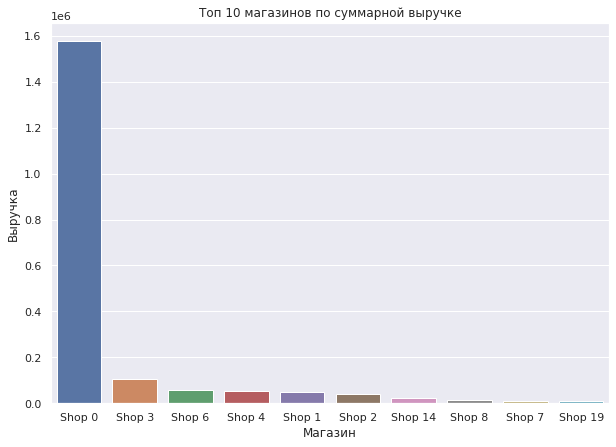

In [40]:
ax = sns.barplot( x = "shop_id", y = "revenue",data=revenue_grouped)
ax.set_title('Топ 10 магазинов по суммарной выручке')
plt.xlabel('Магазин')
plt.ylabel('Выручка')
plt.show()

Самый продающий магазин - Shop 0. Возможно самый первый магазин, флагман сети. Его выручка в 15 раз выше следующего по выручке магазина - Shop 3, остальные - сильно отстающие. Возможно некоторые недавно открылись или есть проблемы с продажами.

### Расчет среднего чека по магазинам

При расчете среднего чека оставляем позиции с возвратами, так как они влияют на прибыль магазина.

У нас есть магазины, в которых небольшая выручка, возможно они недавно открылись. Посмотрим минимальные даты покупок.

In [41]:
shop = retail.pivot_table(index='shop_id',values='date',aggfunc='min').sort_values(by='date')
shop

,date
shop_id,
Shop 0,2016-12-01
Shop 1,2016-12-01
Shop 6,2016-12-01
Shop 5,2016-12-01
Shop 4,2016-12-01
Shop 3,2016-12-01
Shop 2,2016-12-01
Shop 7,2016-12-03
Shop 8,2016-12-03


Итак, мы видим, что магазины нумеруются по мере их открытия. На 01.12.2016 были открыты Shop 0,1,2,3,4,5,6. А по Shop 30 в данных представлен только один день продаж.

Посмотрим магазины, у которых пробито больше 10 чеков

In [42]:
bill_grouped = retail_df.pivot_table(index='shop_id',values='purchase_id',aggfunc='nunique').sort_values(by='purchase_id',ascending = False).reset_index().head(10)
bill_grouped.reset_index(drop = True)

,shop_id,purchase_id
0,Shop 0,4471
1,Shop 4,114
2,Shop 1,90
3,Shop 6,46
4,Shop 12,21
5,Shop 8,20
6,Shop 2,19
7,Shop 10,15
8,Shop 3,15
9,Shop 7,11


Получились магазины, которые работают давно. Оставим для расчета только эти магазины.

In [43]:
shop_list = bill_grouped['shop_id'].sort_values()
shop_list

0     Shop 0
2     Shop 1
7    Shop 10
4    Shop 12
6     Shop 2
8     Shop 3
1     Shop 4
3     Shop 6
9     Shop 7
5     Shop 8
Name: shop_id, dtype: object

Создаем сводную таблицу по среднему чеку

In [44]:
bill_data_filtered = retail_df.loc[retail_df['shop_id'].isin(shop_list)]
bill_data_filtered.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00


In [45]:
mean_bills = (bill_data_filtered.groupby(['shop_id', 'purchase_id']).agg(bill = ('buy_sum', 'sum')).reset_index())\
    .groupby('shop_id').agg(mean_bill = ('bill', 'mean')).sort_values(by = 'mean_bill', ascending = False)\
    .head(10).reset_index()
mean_bills

,shop_id,mean_bill
0,Shop 3,6931.73
1,Shop 2,2132.75
2,Shop 6,1230.36
3,Shop 7,1010.50
4,Shop 8,808.65
5,Shop 10,655.09
6,Shop 1,528.89
7,Shop 4,451.69
8,Shop 0,352.84
9,Shop 12,322.64


Строим график

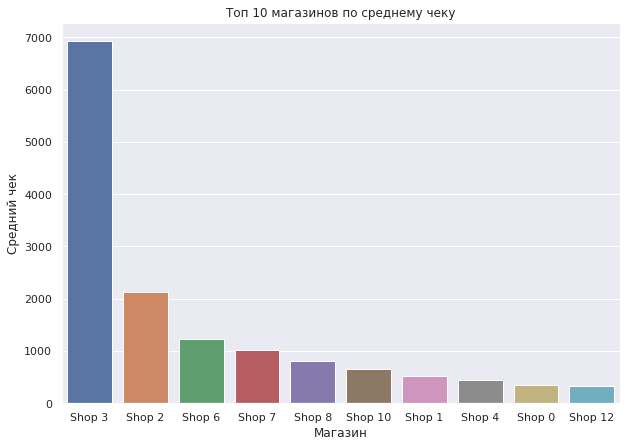

In [46]:
ax = sns.barplot( x = "shop_id", y = "mean_bill",data=mean_bills)
ax.set_title('Топ 10 магазинов по среднему чеку')
plt.xlabel('Магазин')
plt.ylabel('Средний чек')
plt.show()

Видим, что средний чек намного больше у Shop 3. Shop 0 еле ошел в Топ-10 по среднему чеку, хоть и приносит больше всего выручке. возможно все зависит от представленного ассортимента или места нахождения магазина или его формата.

### Расчет среднего количества товаров в чеке по магазинам

Создаем сводную таблицу по среднему количеству товаров

In [47]:
bills_count = (bill_data_filtered.groupby(['shop_id', 'purchase_id']).agg(product = ('product_id', 'count')).reset_index())\
    .groupby('shop_id').agg(mean_product = ('product', 'mean')).sort_values(by = 'mean_product', ascending = False)\
    .head(10).reset_index()
bills_count

,shop_id,mean_product
0,Shop 3,32.80
1,Shop 7,28.36
2,Shop 8,28.00
3,Shop 6,22.43
4,Shop 0,21.78
5,Shop 10,19.93
6,Shop 1,17.11
7,Shop 4,15.27
8,Shop 2,13.32
9,Shop 12,13.24


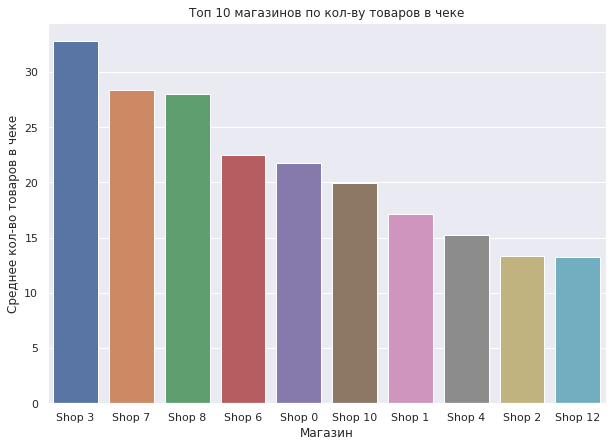

In [48]:
ax = sns.barplot( x = "shop_id", y = "mean_product",data=bills_count)
ax.set_title('Топ 10 магазинов по кол-ву товаров в чеке')
plt.xlabel('Магазин')
plt.ylabel('Среднее кол-во товаров в чеке')
plt.show()

Снова лидирует Shop 3, недалеко от него Shop 7,8

### Расчет среднего количества возвратов по магазинам

Сделаем выборку по отрицательным строчкам и сформируем сводную таблицу

In [49]:
return_data = retail_df.loc[retail_df['buy_sum'] < 0]
print('Количество возвратов:', return_data['purchase_id'].nunique())

Количество возвратов: 979


In [50]:
mean_return = return_data.groupby(['shop_id']).agg(count = ('purchase_id', 'nunique'))\
    .sort_values(by = 'count', ascending = False).reset_index()
mean_return.head()

,shop_id,count
0,Shop 0,888
1,Shop 4,34
2,Shop 1,19
3,Shop 6,9
4,Shop 12,5


По абсолютному значению лидирует Shop 0. Но стоит посмотреть соотношение возвратов к покупкам

In [51]:
mean_buy = retail_df.groupby(['shop_id']).agg(count = ('purchase_id', 'nunique'))\
    .sort_values(by = 'count', ascending = False).reset_index()
mean_buy.head()

,shop_id,count
0,Shop 0,4471
1,Shop 4,114
2,Shop 1,90
3,Shop 6,46
4,Shop 12,21


Объединим таблицы методом merge и добавим столбец с соотношением

In [52]:
buy_return_merge = pd.merge(mean_buy, mean_return, on = 'shop_id', how = 'left')
buy_return_merge.columns = ['shop_id', 'buys', 'returns']

buy_return_merge['ratio, %'] = (buy_return_merge['returns'] / buy_return_merge['buys']) * 100
buy_return_merge.sort_values(by = 'ratio, %', ascending = False, inplace = True)
buy_return_merge.head(10).reset_index()

,index,shop_id,buys,returns,"ratio, %"
0,21,Shop 23,2,1.00,50.00
1,10,Shop 11,10,4.00,40.00
2,20,Shop 21,3,1.00,33.33
3,1,Shop 4,114,34.00,29.82
4,12,Shop 19,7,2.00,28.57
5,17,Shop 16,4,1.00,25.00
6,16,Shop 20,4,1.00,25.00
7,4,Shop 12,21,5.00,23.81
8,2,Shop 1,90,19.00,21.11
9,5,Shop 8,20,4.00,20.00


Посмотрим на возвраты в магазинах из списка, где больше 10 чеков

In [53]:
buy_return_merged = buy_return_merge.loc[buy_return_merge['shop_id'].isin(shop_list)]
buy_return_merged

,shop_id,buys,returns,"ratio, %"
1,Shop 4,114,34.00,29.82
4,Shop 12,21,5.00,23.81
2,Shop 1,90,19.00,21.11
5,Shop 8,20,4.00,20.00
7,Shop 10,15,3.00,20.00
0,Shop 0,4471,888.00,19.86
3,Shop 6,46,9.00,19.57
8,Shop 3,15,2.00,13.33
6,Shop 2,19,2.00,10.53
9,Shop 7,11,1.00,9.09


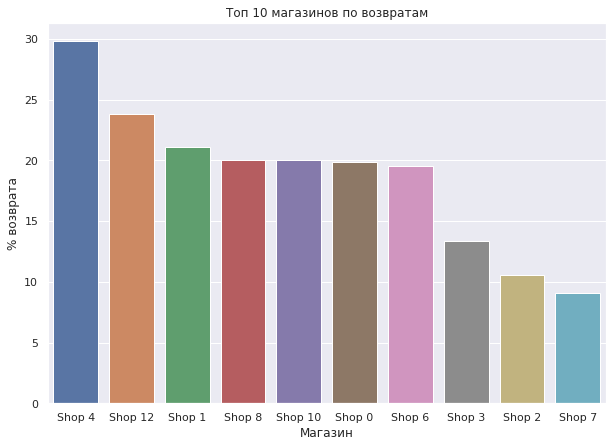

In [54]:
ax = sns.barplot( x = "shop_id", y = "ratio, %",data=buy_return_merged)
ax.set_title('Топ 10 магазинов по возвратам')
plt.xlabel('Магазин')
plt.ylabel('% возврата')
plt.show()

Лидер по % возврата Shop 4, однако Shop 3 и Shop 0 также входят в топ 10. И надо отметить вцелом по сети достаточно большой процент возврата. 

### Распределение количества покупок по программе лояльности 

Построим график распределения покупок с разбивкой на участие в программе лояльности и нет, берем магазины по количеству чека больше 10

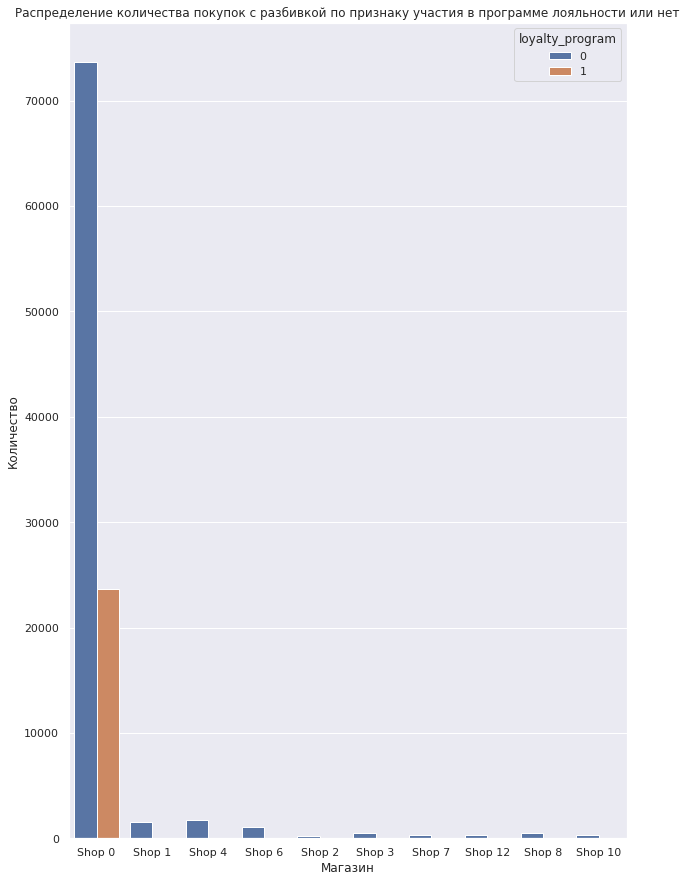

In [55]:
plt.figure(figsize=(10, 15))
sns.countplot(x = bill_data_filtered['shop_id'], hue='loyalty_program', data=bill_data_filtered)
plt.title('Распределение количества покупок с разбивкой по признаку участия в программе лояльности или нет')
plt.xlabel('Магазин')
plt.ylabel('Количество')
plt.show()

Видим, что все участники программы лояльности cовершали покупки в Shop 0.

In [56]:
loy = bill_data_filtered.pivot_table(index='shop_id',values='loyalty_program',aggfunc='sum').sort_values(by='loyalty_program',ascending=False)
loy

,loyalty_program
shop_id,
Shop 0,23701
Shop 8,63
Shop 1,0
Shop 10,0
Shop 12,0
Shop 2,0
Shop 3,0
Shop 4,0
Shop 6,0


Действительно преимущественно покупки по программе лояльности совершались в Shop 0.

### Вывод

Лидером по выручке является магазин Shop 0,в нем совершается большая часть покупок, как вцелом, так и по программе лояльности. В то время Shop 3 лидирует по количеству товаров в чеке и среднему чеке, также имеет низкий процент возврата. По сети очень большой процент возврата, особенно у Shop 4.

## Проверка гипотез

Теперь будем проверять гипотезы как на очищенных данных, так и на нет. Присоединим к очищенному от выбросов датафрейму таблицу product_mean с усредненными ценами:

In [57]:
retail_data_filtered = pd.merge(retail_filter, product_mean, on = 'product_id', how = 'left')
retail_data_filtered['buy_sum'] = retail_data_filtered['quantity'] * retail_data_filtered['mean_price']
retail_data_filtered.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00


Для каждого набора данных создадим два датафрейма: с магазинами, участвующими в программе эффективности, и не входящими в нее:

In [58]:
retail_loyal = retail_df.query('loyalty_program == 1')
retail_unloyal = retail_df.query('loyalty_program == 0')
retail_filtered_loyal = retail_data_filtered.query('loyalty_program == 1')
retail_filtered_unloyal = retail_data_filtered.query('loyalty_program == 0')
df_list = [retail_loyal, retail_unloyal, retail_filtered_loyal, retail_filtered_unloyal]

Посмотрим полученные датафреймы и информацию о них

In [59]:
for df in df_list:
    display(df.head())
    display(df.info())

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00
5,538379,22965,0,2016-12-12 11:26:00,22805,Shop 0,1,2016-12-12,3.07,0.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23842 entries, 1 to 105332
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      23842 non-null  object        
 1   product_id       23842 non-null  object        
 2   quantity         23842 non-null  int64         
 3   purchase_date    23842 non-null  datetime64[ns]
 4   customer_id      23842 non-null  int64         
 5   shop_id          23842 non-null  object        
 6   loyalty_program  23842 non-null  int64         
 7   date             23842 non-null  datetime64[ns]
 8   mean_price       23842 non-null  float64       
 9   buy_sum          23842 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 2.0+ MB


None

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
6,540468,22189,0,2017-01-07 13:55:00,1,Shop 0,0,2017-01-07,5.28,0.00
7,541424,79321,1,2017-01-17 17:57:00,1,Shop 0,0,2017-01-17,7.01,7.01
8,538883,22891,0,2016-12-14 15:56:00,1,Shop 0,0,2016-12-14,6.19,0.00
11,541696,22197,4,2017-01-20 18:08:00,1,Shop 0,0,2017-01-20,1.21,4.86


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81493 entries, 0 to 105334
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      81493 non-null  object        
 1   product_id       81493 non-null  object        
 2   quantity         81493 non-null  int64         
 3   purchase_date    81493 non-null  datetime64[ns]
 4   customer_id      81493 non-null  int64         
 5   shop_id          81493 non-null  object        
 6   loyalty_program  81493 non-null  int64         
 7   date             81493 non-null  datetime64[ns]
 8   mean_price       81493 non-null  float64       
 9   buy_sum          81493 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 6.8+ MB


None

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00
5,538379,22965,0,2016-12-12 11:26:00,22805,Shop 0,1,2016-12-12,3.07,0.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 1 to 100427
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      22641 non-null  object        
 1   product_id       22641 non-null  object        
 2   quantity         22641 non-null  int64         
 3   purchase_date    22641 non-null  datetime64[ns]
 4   customer_id      22641 non-null  int64         
 5   shop_id          22641 non-null  object        
 6   loyalty_program  22641 non-null  int64         
 7   date             22641 non-null  datetime64[ns]
 8   mean_price       22641 non-null  float64       
 9   buy_sum          22641 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 1.9+ MB


None

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
6,540468,22189,0,2017-01-07 13:55:00,1,Shop 0,0,2017-01-07,5.28,0.00
7,541424,79321,1,2017-01-17 17:57:00,1,Shop 0,0,2017-01-17,7.01,7.01
8,538883,22891,0,2016-12-14 15:56:00,1,Shop 0,0,2016-12-14,6.19,0.00
11,541696,22197,4,2017-01-20 18:08:00,1,Shop 0,0,2017-01-20,1.21,4.86


<class 'pandas.core.frame.DataFrame'>
Int64Index: 77789 entries, 0 to 100429
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      77789 non-null  object        
 1   product_id       77789 non-null  object        
 2   quantity         77789 non-null  int64         
 3   purchase_date    77789 non-null  datetime64[ns]
 4   customer_id      77789 non-null  int64         
 5   shop_id          77789 non-null  object        
 6   loyalty_program  77789 non-null  int64         
 7   date             77789 non-null  datetime64[ns]
 8   mean_price       77789 non-null  float64       
 9   buy_sum          77789 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 6.5+ MB


None

Видим, что строчек в датафреймах о покупках участников программ лояльности меньше в разы.Размеры выборок для тестов будут сильно отличаться, это не очень хорошо, но выбора нет

In [60]:
def ttests(loyal, unloyal, filt_loyal, filt_unloyal, equal, equal_filt):
    
    alpha = .05  
    results = st.ttest_ind(loyal, unloyal, equal_var = equal)
    results_filt = st.ttest_ind(filt_loyal, filt_unloyal, equal_var = equal_filt)
    print('p-значение: {:.3f}'.format(results.pvalue))
    if (results.pvalue < alpha):
        print('Средние значения выборок по участию в программе лояльности различаются,\
 отвергаем нулевую гипотезу.')
    else:
        print('Средние значения выборок по участию в программе лояльности не различаются,\
 не отвергаем нулевую гипотезу.')
        
    print('p-значение filtered: {:.3f}'.format(results_filt.pvalue))
    if (results_filt.pvalue < alpha):
        print('Средние значения выборок по участию в программе лояльности различаются,\
 отвергаем нулевую гипотезу.')
    else:
        print('Средние значения выборок по участию в программе лояльности не различаются,\
  не отвергаем нулевую гипотезу.')

### Гипотеза о равенстве средних чеков

Считаем суммы среднего чека для каждого датафрейма

In [61]:
loyal_bill = retail_loyal.groupby('purchase_id')['buy_sum'].sum()
unloyal_bill = retail_unloyal.groupby('purchase_id')['buy_sum'].sum()
loyal_filtered_bill = retail_filtered_loyal.groupby('purchase_id')['buy_sum'].sum()
unloyal_filtered_bill = retail_filtered_unloyal.groupby('purchase_id')['buy_sum'].sum()

In [62]:
loyal_bill.head()

purchase_id
536365   184.47
536366    20.40
536372    20.40
536373   384.53
536375   384.53
Name: buy_sum, dtype: float64

Формулируем гипотезы:

*Н0: Средние чеки магазинов участвующих в программе лояльности, и не участвующих в ней, не различаются.

*Н1: Средние чеки магазинов участвующих в программе лояльности, и не участвующих в ней, различны.

In [63]:
ttests(loyal_bill,unloyal_bill,loyal_filtered_bill ,unloyal_filtered_bill,False,False)

p-значение: 0.211
Средние значения выборок по участию в программе лояльности не различаются, не отвергаем нулевую гипотезу.
p-значение filtered: 0.176
Средние значения выборок по участию в программе лояльности не различаются,  не отвергаем нулевую гипотезу.


По t-test видим, что средний чеки магазинов участвующих в программе лояльности, и не участвующих в ней, не различаются. Посчитаем средние значения

In [64]:
mean_bill = (retail_df.groupby(['purchase_id', 'loyalty_program']).agg({'buy_sum': 'sum'}).reset_index())\
    .groupby('loyalty_program').agg(mean_bill = ('buy_sum', 'mean')).reset_index()
mean_bill

,loyalty_program,mean_bill
0,0,388.82
1,1,463.05


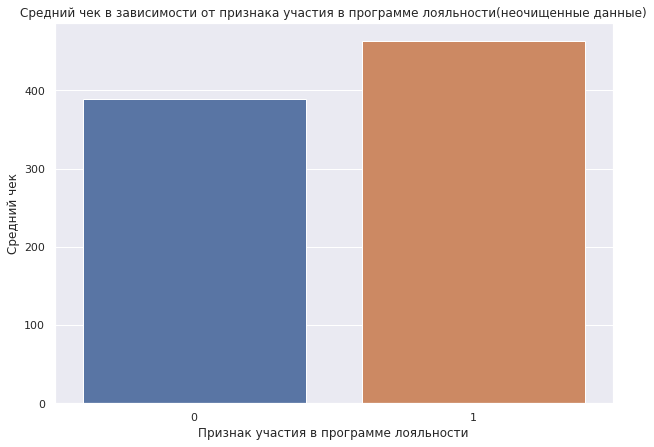

In [65]:
ax = sns.barplot(x='loyalty_program',y='mean_bill',data=mean_bill)
ax.set_title('Средний чек в зависимости от признака участия в программе лояльности(неочищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Средний чек')
plt.show()

In [66]:
mean_bill_fl = (retail_data_filtered.groupby(['purchase_id', 'loyalty_program']).agg({'buy_sum': 'sum'}).reset_index())\
    .groupby('loyalty_program').agg(mean_bill = ('buy_sum', 'mean')).reset_index()
mean_bill_fl

,loyalty_program,mean_bill
0,0,229.10
1,1,260.61


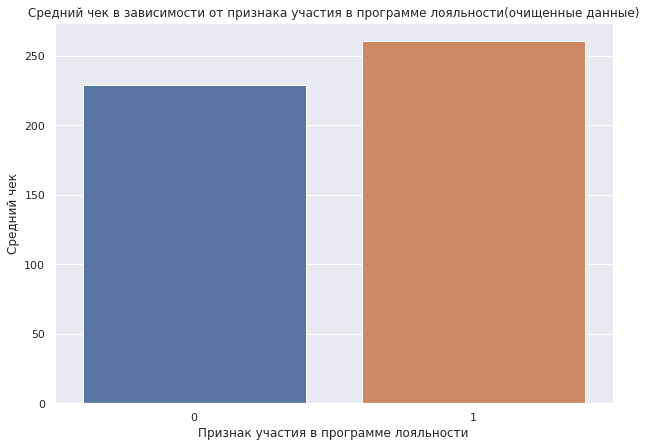

In [67]:
ax = sns.barplot(x='loyalty_program',y='mean_bill',data=mean_bill_fl)
ax.set_title('Средний чек в зависимости от признака участия в программе лояльности(очищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Средний чек')
plt.show()

Судя по полученным средним значениям, мы видим обратную картину, средний чек у участников программы лояльности выше, различия есть.

Возможно t-test показал некорректный результат из-за того, что выборки разные по размеру. Проведем тест методом Манна-Уитни, напишем функцию 

In [68]:
def mw(loyal, unloyal, filt_loyal, filt_unloyal):
    alpha = .05    
    results = st.mannwhitneyu(loyal, unloyal)
    results_filt = st.mannwhitneyu(filt_loyal, filt_unloyal)
    print('p-значение: {:.3f}'.format(results.pvalue))
    if (results.pvalue < alpha):
        print('Средние значения выборок по участию в программе лояльности различаются,\
отвергаем нулевую гипотезу.')
    else:
        print('Средние значения выборок по участию в программе лояльности не различаются,\
  не отвергаем нулевую гипотезу.')
        
    print('p-значение filtered: {:.3f}'.format(results_filt.pvalue))
    if (results_filt.pvalue < alpha):
        print('Средние значения выборок по участию в программе лояльности различаются,\
 отвергаем нулевую гипотезу.')
    else:
        print('Средние значения выборок по участию в программе лояльности не различаются,\
 не отвергаем нулевую гипотезу.')

In [69]:
mw(loyal_bill, unloyal_bill, loyal_filtered_bill, unloyal_filtered_bill)

p-значение: 0.000
Средние значения выборок по участию в программе лояльности различаются,отвергаем нулевую гипотезу.
p-значение filtered: 0.047
Средние значения выборок по участию в программе лояльности различаются, отвергаем нулевую гипотезу.


Тест методом Манна-Уитни показывает, что есть статистические различия между среднем чеком участника программы лояльности и не участника

### Гипотеза о равенстве среднего количества позиций в чеке

Проверим различие в среднем количестве позиции товаров в чеке

In [70]:
loyal_pr = retail_loyal.groupby('purchase_id')['product_id'].count()
unloyal_pr = retail_unloyal.groupby('purchase_id')['product_id'].count()
loyal_filtered_pr = retail_filtered_loyal.groupby('purchase_id')['product_id'].count()
unloyal_filtered_pr = retail_filtered_unloyal.groupby('purchase_id')['product_id'].count()
#проверим результат на одном из списков
loyal_pr.head()

purchase_id
536365     7
536366     2
536372     2
536373    16
536375    16
Name: product_id, dtype: int64

Формулируем гипотезы

*Н0: Средние количество позиций в чеках магазинов, участвующих в программе лояльности, и не участвующих в ней, не различаются

*Н1: Средние количество позиций в чеках магазинов, участвующих в программе лояльности, и не участвующих в ней, различны.

In [71]:
ttests(loyal_pr ,unloyal_pr, loyal_filtered_pr,unloyal_filtered_pr, False, False)

p-значение: 0.000
Средние значения выборок по участию в программе лояльности различаются, отвергаем нулевую гипотезу.
p-значение filtered: 0.000
Средние значения выборок по участию в программе лояльности различаются, отвергаем нулевую гипотезу.


Средние количество позиций в чеках магазинов, участвующих в программе лояльности, и не участвующих в ней, различны по итогам теста. Посчитаем средние значения

In [72]:
pr_count = (retail_df.groupby(['purchase_id', 'loyalty_program']).agg({'product_id': 'count'}).reset_index())\
    .groupby('loyalty_program').agg(pr_count = ('product_id', 'mean')).reset_index()
pr_count

,loyalty_program,pr_count
0,0,22.96
1,1,17.74


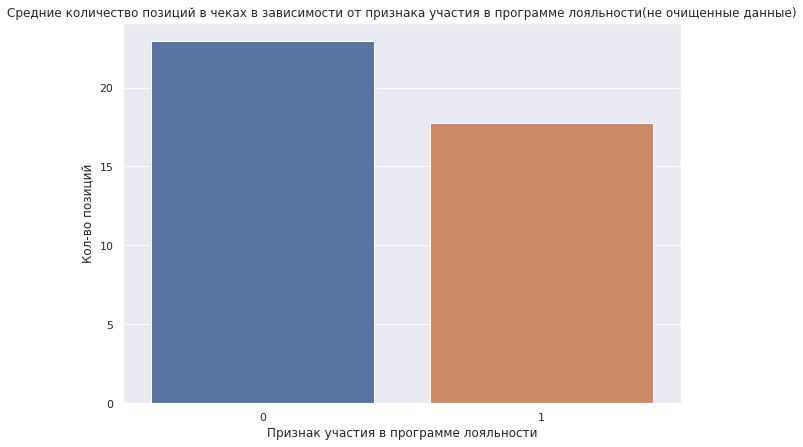

In [73]:
ax = sns.barplot(x='loyalty_program',y='pr_count',data=pr_count)
ax.set_title('Средние количество позиций в чеках в зависимости от признака участия в программе лояльности(не очищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Кол-во позиций')
plt.show()

In [74]:
pr_count_fl = retail_data_filtered.groupby(['purchase_id', 'loyalty_program']).agg({'product_id': 'count'}).reset_index()\
    .groupby('loyalty_program').agg(pr_count = ('product_id', 'mean')).reset_index()
pr_count_fl

,loyalty_program,pr_count
0,0,24.20
1,1,17.91


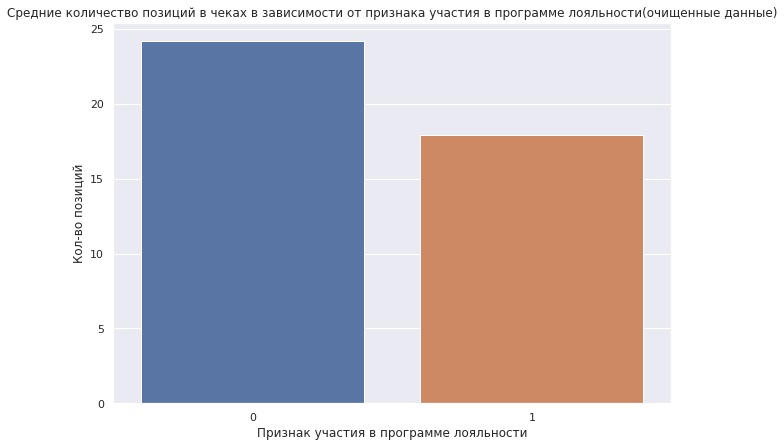

In [75]:
ax = sns.barplot(x='loyalty_program',y='pr_count',data=pr_count_fl)
ax.set_title('Средние количество позиций в чеках в зависимости от признака участия в программе лояльности(очищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Кол-во позиций')
plt.show()

Действительно количество товаров в чеках достаточно сильно отличается. И меньше их для участников программы лояльности. По данному критерию программу лояльности можно считать неэффективной.

### Гипотеза о равенстве среднем количестве позиций в чеке

Сгруппируем данные по среднему количетству покупок в чеке по магазинам, удалим пользователя с customer_id = 1:

In [76]:
loyal_buys = retail_loyal.query('customer_id != 1').groupby('customer_id')['purchase_id'].nunique()
unloyal_buys = retail_unloyal.query('customer_id != 1').groupby('customer_id')['purchase_id'].nunique()
loyal_filtered_buys = retail_filtered_loyal.query('customer_id != 1').groupby('customer_id')['purchase_id'].nunique()
unloyal_filtered_buys = retail_filtered_unloyal.query('customer_id != 1').groupby('customer_id')['purchase_id'].nunique()
#проверис результат на одном из списков
loyal_buys.head()

customer_id
22005    2
22006    2
22011    1
22012    3
22018    1
Name: purchase_id, dtype: int64

Формулируем гипотезы:

*Н0 Среднее количество покупок на одного покупателя в магазинах, участвующих в программе лояльности, и не участвующих в ней, не различаются.

*Н1  Среднее количество покупок на одного покупателя в магазинах, участвующих в программе лояльности, и не участвующих в ней, различны.

In [77]:
ttests(loyal_buys, unloyal_buys, loyal_filtered_buys, unloyal_filtered_buys, False, False)

p-значение: 0.384
Средние значения выборок по участию в программе лояльности не различаются, не отвергаем нулевую гипотезу.
p-значение filtered: 0.373
Средние значения выборок по участию в программе лояльности не различаются,  не отвергаем нулевую гипотезу.


Тест показывает, что различий ме;ду средним количеством покупок на одного покупателя нет. Посчитаем среднее

In [78]:
buy = (retail_df.query('customer_id != 1').groupby(['customer_id', 'loyalty_program']).agg({'purchase_id': 'nunique'})\
 .reset_index()).groupby('loyalty_program').agg(mean_buys = ('purchase_id', 'mean')).reset_index()
buy

,loyalty_program,mean_buys
0,0,2.41
1,1,2.29


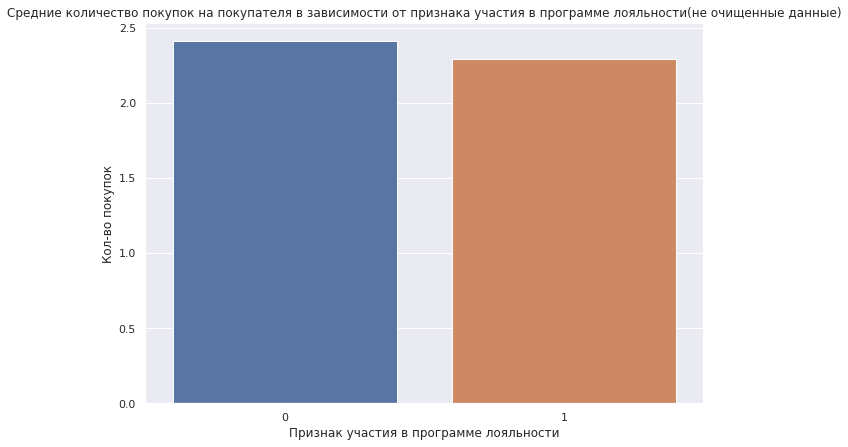

In [79]:
ax = sns.barplot(x='loyalty_program',y='mean_buys',data=buy)
ax.set_title('Средние количество покупок на покупателя в зависимости от признака участия в программе лояльности(не очищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Кол-во покупок')
plt.show()

In [80]:
buy_fl = (retail_data_filtered.query('customer_id != 1').groupby(['customer_id', 'loyalty_program']).agg({'purchase_id': 'nunique'})\
 .reset_index()).groupby('loyalty_program').agg(mean_buys = ('purchase_id', 'mean')).reset_index()
buy_fl

,loyalty_program,mean_buys
0,0,2.34
1,1,2.22


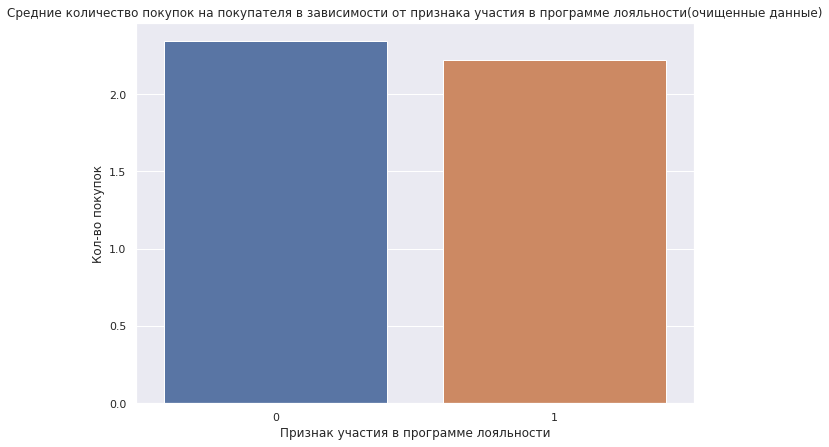

In [81]:
ax = sns.barplot(x='loyalty_program',y='mean_buys',data=buy_fl)
ax.set_title('Средние количество покупок на покупателя в зависимости от признака участия в программе лояльности(очищенные данные)')
plt.xlabel('Признак участия в программе лояльности')
plt.ylabel('Кол-во покупок')
plt.show()

Среднее количество позиций в чеке не зависит от участия в программе лояльности.

### Вывод

Тесты показали, что у нас есть различия в среднем чеке и в среднем количестве позиций в чеке участника программы лояльности и не участника. При этом количество позиций участника программы ниже, а среднее количество покупок одинаково с не участником программы.

## Выводы и рекомендации

В ходе исследования была проведена работа с исходными данными, удалены выбросы и усреднены цены на товар.

В ходе анализа данных выявлены лучшие магазины: Shop 0 и Shop 3. Shop 0 - магазин с самой большой выручкой и самым большим количеством покупок по программе лояльности.Shop 3 - лидер по показателям среднего чека, количества позиций в чеке и низким процентом возврата. Следует обратить внимание на этот магазин для дальнейшего развития. Также в сети большой процент возврата, стоит обратить внимание на это, задуматься о качестве товара, о предотвращении покупок не правильных товаров, лучше консультировать покупателя.

Самый главный показатель эффективности - средний чек, а также количество позиций в чеке. Были проведены статистические тесты, которые показали, что есть статистические различия среднего чека участника программы лояльности от не участника. У участника он выше, что и показал абсолютный показатель.  А вот количество позиций в чеке для участников программы лояльности заметно ниже, чем для обычных покупателей. А среднее количество покупок для обеих групп практически равно.

Таким образом, считаю, что программа лояльности в магазине малоэффективна. Её стоит доработать, изменить условия, предлагать бонусы для стимулирования покупателей покупать больше товаров и чаще.

## Дополнительные работы 

In [83]:
retail_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100430 entries, 0 to 100429
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      100430 non-null  object        
 1   product_id       100430 non-null  object        
 2   quantity         100430 non-null  int64         
 3   purchase_date    100430 non-null  datetime64[ns]
 4   customer_id      100430 non-null  int64         
 5   shop_id          100430 non-null  object        
 6   loyalty_program  100430 non-null  int64         
 7   date             100430 non-null  datetime64[ns]
 8   mean_price       100430 non-null  float64       
 9   buy_sum          100430 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 8.4+ MB


In [92]:
retail_data = retail_data_filtered.loc[retail_data_filtered['purchase_id'].str.contains('[A-Z]+'), :]
retail_data

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
62,C539944,22776,-2,2016-12-23 11:38:00,20239,Shop 0,0,2016-12-23,14.70,-29.39
104,C542910,20726,-2,2017-02-01 15:38:00,23190,Shop 0,1,2017-02-01,3.07,-6.13
107,C542426,22418,-25,2017-01-28 09:32:00,19825,Shop 0,0,2017-01-28,1.66,-41.56
243,C539726,22791,-11,2016-12-21 14:24:00,22686,Shop 0,1,2016-12-21,1.82,-20.02
330,C544034,21878,-2,2017-02-15 11:28:00,20380,Shop 0,0,2017-02-15,1.21,-2.43
...,...,...,...,...,...,...,...,...,...,...
100262,C541650,M,-2,2017-01-20 11:44:00,1,Shop 0,0,2017-01-20,253.77,-507.53
100273,C540246,79320,-2,2017-01-05 15:43:00,18760,Shop 0,0,2017-01-05,4.95,-9.90
100309,C539467,22801,-2,2016-12-19 12:46:00,20723,Shop 0,0,2016-12-19,5.56,-11.11
100347,C540847,22197,-3,2017-01-11 17:35:00,19137,Shop 0,0,2017-01-11,1.21,-3.64


In [97]:
retail_last = retail_data_filtered.loc[retail_data_filtered['purchase_id'].str.startswith("C")]
retail_last

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
62,C539944,22776,-2,2016-12-23 11:38:00,20239,Shop 0,0,2016-12-23,14.70,-29.39
104,C542910,20726,-2,2017-02-01 15:38:00,23190,Shop 0,1,2017-02-01,3.07,-6.13
107,C542426,22418,-25,2017-01-28 09:32:00,19825,Shop 0,0,2017-01-28,1.66,-41.56
243,C539726,22791,-11,2016-12-21 14:24:00,22686,Shop 0,1,2016-12-21,1.82,-20.02
330,C544034,21878,-2,2017-02-15 11:28:00,20380,Shop 0,0,2017-02-15,1.21,-2.43
...,...,...,...,...,...,...,...,...,...,...
100262,C541650,M,-2,2017-01-20 11:44:00,1,Shop 0,0,2017-01-20,253.77,-507.53
100273,C540246,79320,-2,2017-01-05 15:43:00,18760,Shop 0,0,2017-01-05,4.95,-9.90
100309,C539467,22801,-2,2016-12-19 12:46:00,20723,Shop 0,0,2016-12-19,5.56,-11.11
100347,C540847,22197,-3,2017-01-11 17:35:00,19137,Shop 0,0,2017-01-11,1.21,-3.64


In [102]:
retail_last = retail_data_filtered[~retail_data_filtered['purchase_id'].str.startswith("C")]
retail_last

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,mean_price,buy_sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,2016-12-10,1.81,19.91
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2016-12-14,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1,2016-12-14,1.47,10.32
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,2017-02-09,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,2017-02-13,7.01,0.00
...,...,...,...,...,...,...,...,...,...,...
100425,538566,21826,1,2016-12-13 11:21:00,1,Shop 0,0,2016-12-13,2.07,2.07
100426,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,0,2017-01-05,9.34,0.00
100427,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,1,2016-12-09,11.37,11.37
100428,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,0,2016-12-10,0.70,7.70


In [ ]:
(retail_last.query('customer_id != 1').groupby(['customer_id', 'purchase_id']).agg({'purchase_id': 'nunique'})\
 .reset_index())

In [105]:
retail_last.to_csv('retail_last.csv', index=False)